# Classification Example
Latent Dimensionality Reduction applied to the [Wisconsin breat cancer data set](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html).

Useful because of the ability to backtrack from a model, and identify what metrics are significant indicators of issues.

In [29]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.svm import OneClassSVM
from sklearn import svm
from sklearn.neighbors import KernelDensity

from ldr import LDR

In [25]:
plt.style.use("illumina.mplstyle")

## Preprocessing

Load dataset. The breast cancer data set is used as it has a good number of samples for model training, and a number of dimensions that will result in a significantly difficult to interpret model.

In [3]:
data = load_breast_cancer()
df = pd.DataFrame(data.data, columns=data.feature_names)
df["species"] = pd.Categorical.from_codes(data.target, data.target_names)
print(df["species"].value_counts())
print("Shape:", df.shape)
df.head()

benign       357
malignant    212
Name: species, dtype: int64
Shape: (569, 31)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,species
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,malignant
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,malignant
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,malignant
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,malignant
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,malignant


In [4]:
# pos = df[df["species"] == "malignant"][:int(df.shape[0] * 0.2)]
pos = df[df["species"] == "malignant"]
neg = df[df["species"] == "benign"]
df = pd.concat([pos, neg])

In [5]:
print(neg.shape, pos.shape)

(357, 31) (212, 31)


Drop species as this is the target.

In [6]:
targets = df["species"]
df = df.drop(["species"], axis=1)

Scale the data.

In [9]:
ldr = LDR(df, targets, "class", pos_val="benign", neg_val="malignant")

Class balance fixed, Negatives: 357 , Positives: 357


In [10]:
# ldr.scatter_plot_matrix()

In [11]:
# Train classifier and check accuracy.
X_train, X_test, y_train, y_test = train_test_split(
    ldr.scaled, ldr.targets, test_size=0.33, random_state=42)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)
preds = rf_clf.predict(X_test)
print("F1 score:", f1_score(y_test, preds, pos_label="malignant"))
print("Confusion matrix:")
print(confusion_matrix(y_test, preds))

F1 score: 0.9746835443037976
Confusion matrix:
[[107   1]
 [  3  77]]


## Classifier Training and Analysis

### Random Forests

In [158]:
def rf_clf_func(df):
    proba = rf_clf.predict_proba(df)
    return np.array([i[1] for i in proba])

In [166]:
ldr.density_estimate(rf_clf_func, n=150000, k_dens=0.02, n_bins=51)

Select 5 most important features to visualize.

In [167]:
# features = [(f, i) for f, i in zip(X_train.columns, rf_clf.feature_importances_)]   
# features.sort(key=lambda x: x[1], reverse=True)
# features = [i[0] for i in features[:5]]
# print(features)

features = ["mean area", "mean symmetry", "mean compactness"]

ldr.select_bins(features, n_bins=51)

In [168]:
ldr.D.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,prediction
0,0.340236,0.381086,0.291604,0.199196,0.250138,0.138912,0.073287,0.064775,0.357013,0.129585,...,0.462618,0.238356,0.113923,0.269197,0.168301,0.189362,0.388916,0.281654,0.093187,0.17
1,0.488393,0.398288,0.475289,0.308444,0.388400,0.356457,0.305122,0.324077,0.449780,0.116448,...,0.437361,0.373415,0.254286,0.610362,0.367501,0.428155,0.625569,0.637507,0.195875,1.00
2,0.204062,0.199793,0.210265,0.119782,0.272178,0.318512,0.230209,0.138935,0.350985,0.465313,...,0.164350,0.143276,0.041352,0.257005,0.247710,0.241722,0.285038,0.107353,0.320860,0.00
3,0.356302,0.201747,0.315004,0.189396,0.317434,0.120590,0.036419,0.074353,0.197746,0.167583,...,0.376697,0.199971,0.122638,0.281970,0.103165,0.033145,0.196951,0.149926,0.083007,0.01
4,0.246366,0.208695,0.225702,0.169474,0.246893,0.016489,0.022516,0.053617,0.237646,0.171309,...,0.236763,0.149089,0.111926,0.233303,0.067762,0.037643,0.125773,0.257886,0.056426,0.00


Bar Chart Example

<BarContainer object of 50 artists>

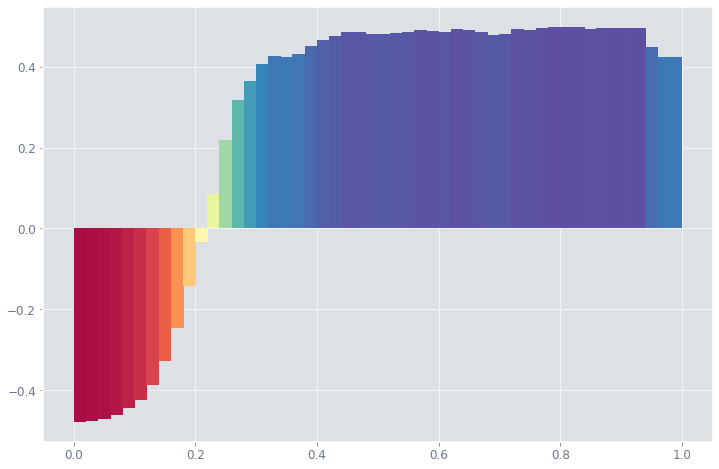

In [169]:
# Select mid values of intervals for x values.
Cols = plt.get_cmap("Spectral")
bar_vals = ldr.D_bins[features[0]] - 0.5
x = [i.mid for i in np.array(bar_vals.keys())]
y = bar_vals.values
c = [Cols(i+0.5) for i in y]

plt.bar(x=x, height=y, width=1 / len(x) * 1.05, color=c)

2D contour example

In [170]:

print(mid_points)

[0.01 0.03 0.05 0.07 0.09 0.11 0.13 0.15 0.17 0.19 0.21 0.23 0.25 0.27
 0.29 0.31 0.33 0.35 0.37 0.39 0.41 0.43 0.45 0.47 0.49 0.51 0.53 0.55
 0.57 0.59 0.61 0.63 0.65 0.67 0.69 0.71 0.73 0.75 0.77 0.79 0.81 0.83
 0.85 0.87 0.89 0.91 0.93 0.95 0.97 0.99]


In [171]:
ldr.D.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,prediction
0,0.340236,0.381086,0.291604,0.199196,0.250138,0.138912,0.073287,0.064775,0.357013,0.129585,...,0.462618,0.238356,0.113923,0.269197,0.168301,0.189362,0.388916,0.281654,0.093187,0.17
1,0.488393,0.398288,0.475289,0.308444,0.388400,0.356457,0.305122,0.324077,0.449780,0.116448,...,0.437361,0.373415,0.254286,0.610362,0.367501,0.428155,0.625569,0.637507,0.195875,1.00
2,0.204062,0.199793,0.210265,0.119782,0.272178,0.318512,0.230209,0.138935,0.350985,0.465313,...,0.164350,0.143276,0.041352,0.257005,0.247710,0.241722,0.285038,0.107353,0.320860,0.00
3,0.356302,0.201747,0.315004,0.189396,0.317434,0.120590,0.036419,0.074353,0.197746,0.167583,...,0.376697,0.199971,0.122638,0.281970,0.103165,0.033145,0.196951,0.149926,0.083007,0.01
4,0.246366,0.208695,0.225702,0.169474,0.246893,0.016489,0.022516,0.053617,0.237646,0.171309,...,0.236763,0.149089,0.111926,0.233303,0.067762,0.037643,0.125773,0.257886,0.056426,0.00


mesh complete


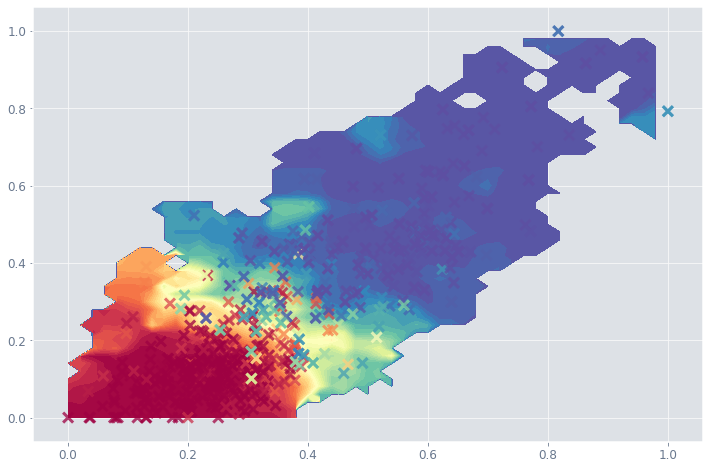

In [172]:
# Create an entry matrix first.
col1, col2, colp = "mean radius", "mean concave points", "prediction"
res_sub = np.linspace(0.0, 1.0, ldr.n_bins)
Zm = [[[] for i in res_sub] for j in res_sub]

# Find midpoints of each bin.
mid_points = np.array([i.mid for i in ldr.D_bins.index])

# Finds nearest point of a value in an array.
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

# Go through each prediction based on KDE and put into nearest bin.
for d, d_val in ldr.D.iterrows():
    col1_ind = int(find_nearest(mid_points, d_val[col1]) * (ldr.n_bins - 1) - 0.5)
    col2_ind = int(find_nearest(mid_points, d_val[col2]) * (ldr.n_bins - 1) - 0.5)
    Zm[col1_ind][col2_ind].append(d_val["prediction"])

# Take the mean of value, move down to mid at 0, make outliers 100 so not drawn.
Zm = [[np.mean(Zm[i][j]) - 0.5 if len(Zm[i][j]) > 0 else 100
       for i in range(ldr.n_bins)] for j in range(ldr.n_bins)]

colors = plt.get_cmap("Spectral")

Xm, Ym = np.meshgrid(res_sub, res_sub)
print("mesh complete")
plt.contourf(Xm, Ym, Zm, levels=np.linspace(-0.5, 0.5, 41), cmap="Spectral")
plt.scatter(ldr.scaled_w[col1],
            ldr.scaled_w[col2],
                   c=colors(ldr.scaled_w_preds),
#                    c="#ff0000",
                   marker="x",
                   alpha=0.75,
                   zorder=1)
plt.show()

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


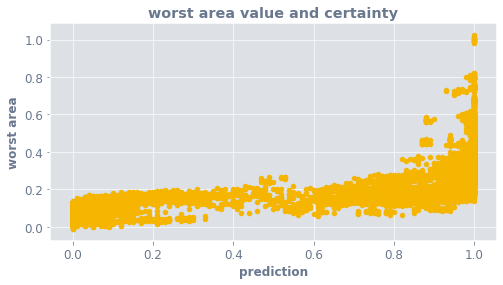

In [126]:
ldr.density_scatter("worst area")

In [ ]:
ldr.scatter_plot_matrix(features)

In [ ]:
ldr.vis_1d(figsize=(32, 8))

Everything red will be classified as malignant, everything blue will be classified as benign.

In [ ]:
ldr.vis_2d()

### One Class SVM
Used for outlier detection/estimating a learning frontier. The SVM is set to use 10% of points estimated as outliers to set the learning frontier.

In [ ]:
oc_clf = OneClassSVM(gamma='auto', nu=0.1).fit(X_train)

In [ ]:
def oc_clf_func(df):
    pred = oc_clf.predict(df)
    return [(i + 1) / 2 for i in pred]

In [ ]:
tst = oc_clf_func(X_train)
pd.Series(tst).value_counts()

In [ ]:
ldr.density_estimate(oc_clf_func, n=10000)

In [ ]:
ldr.density_scatter("mean smoothness")

In [ ]:
ldr.select_1d_bins(features, n_bins=25)

In [ ]:
ldr.scatter_plot_matrix(features)

In [ ]:
ldr.vis_1d(figsize=(32, 8))

Red will be classified as within range of the classifier, while blue will be classified as outliers.

In [ ]:
ldr.vis_2d()

## Random Forest Classifier and Outlier Detection Superposition

In [ ]:
def oc_rf_clf_func(df):
    oc_pred = oc_clf_func(df)
    rf_pred = rf_clf_func(df)
    return [(rf_pred[i] - 0.5) * i_val + 0.5 for i, i_val in enumerate(oc_pred)]

In [ ]:
tst = oc_rf_clf_func(X_train[:30])
print(tst[:30])

In [ ]:
ldr.density_estimate(oc_rf_clf_func, n=10000)

In [ ]:
ldr.density_scatter(features[1])

In [ ]:
ldr.select_1d_bins(features, n_bins=25)

In [ ]:
ldr.vis_1d(figsize=(32, 8))

The areas where the classifier is uncertain have been superposed with the areas where samples are taken where training data is not present. The dark colours are strong indicates of good quality accross dimensions.

In [ ]:
ldr.vis_2d()

## Neural Network

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 30 dimensions go in, 2 go out. The 2 coming out are the two
        # different classes available.
        self.fc1 = nn.Linear(X_train.shape[1], 3)
        self.fc2 = nn.Linear(3, 2)

    def forward(self, x):
        x = self.fc1(x)
        x = F.tanh(x)
        x = self.fc2(x)
        return x

    def predict(self, x):
        # Calculate probabilities of each class.
        pred = F.softmax(self.forward(x))
        
        # Return the largest weighted class.
        return torch.tensor([0 if i[0] > i[1] else 1 for i in pred])
    
    def predict_proba(self, x):
        # Calculate probabilities of each class.
        pred = F.softmax(self.forward(x))
        
        # Return the largest weighted class.
        return torch.tensor([i[1] / (i[0] + i[1]) for i in pred])

This may need to be rerun to prevent the stochastic trap.

In [ ]:
net = Net()

# Prepare data for neural network.
inputs = torch.FloatTensor(X_train.values)
labels = torch.LongTensor([1 if i == "malignant" else 0 for i in y_train])

# Optimizer to speed things up, cross entropy loss as it is a classifcation problem.
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.01)
epochs = 30000

losses = []
for epoch in range(epochs):
    outputs = net.forward(inputs)
    loss = criterion(outputs, labels)
    losses.append(loss)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 1000 == 0:
        print("epoch:", epoch, "loss:", loss)
    
print('Finished Training ')

Test NN accuracy.

In [ ]:
test_input = torch.FloatTensor(X_test.values)
preds = np.array(net.predict(test_input))
test_labels = [1 if i == "malignant" else 0 for i in y_test]
print(preds)
print("F1 score:", f1_score(test_labels, preds, pos_label=1))
print("Confusion matrix:")
print(confusion_matrix(test_labels, preds))

The actual classifier function uses the raw certainty of the model.

In [ ]:
preds = np.array(net.predict_proba(test_input))
for i in zip(preds, test_labels):
    print(i)

In [ ]:
# Certainty 
def nn_clf_func(df):
    test_tensor = torch.FloatTensor(df.values)
    return np.array(net.predict_proba(test_tensor))

In [ ]:
ldr.density_estimate(nn_clf_func, n=10000)

In [ ]:
ldr.density_scatter("worst area")

In [ ]:
ldr.select_1d_bins(features, n_bins=25)
ldr.vis_1d(figsize=(32, 8))
ldr.vis_2d()

## NN Classifier and Outlier Detection Superposition

In [ ]:
# Certainty 
def oc_nn_clf_func(df):
    oc_pred = oc_clf_func(df)
    nn_pred = nn_clf_func(df)
    return [(nn_pred[i] - 0.5) * i_val + 0.5 for i, i_val in enumerate(oc_pred)]

In [ ]:
tst = oc_nn_clf_func(X_train)
print(tst[:30])

In [ ]:
ldr.density_estimate(oc_nn_clf_func, n=10000)
ldr.density_scatter(features[1])
ldr.vis_1d_separate("Breast Cancer Feature Effects on Diagnosis")
ldr.select_1d_bins(features, n_bins=50)
ldr.vis_1d(figsize=(32, 8))
ldr.vis_2d()